In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.stats.diagnostic import normal_ad
from scipy import stats

In [2]:
df = pd.read_csv('car data.csv')

In [3]:
df.head(5)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
df.describe(include='number')

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [6]:
df.describe(include='object')

,Car_Name,Fuel_Type,Seller_Type,Transmission
count,301,301,301,301
unique,98,3,2,2
top,city,Petrol,Dealer,Manual
freq,26,239,195,261


## Data Preprocessing

### Feature Selection

In [7]:
df.drop('Car_Name', axis=1, inplace=True)

### Feature Transformation

In [8]:
df.insert(0, "Age", df["Year"].max()+1-df["Year"] )
df.drop('Year', axis=1, inplace=True)
df.head()

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,5,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,6,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,8,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,5,4.60,6.87,42450,Diesel,Dealer,Manual,0


### Missing Values & Duplicates

In [9]:
df.isnull().sum()

Age              0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [10]:
df[df.duplicated(keep=False)]

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
15,3,7.75,10.79,43000,Diesel,Dealer,Manual,0
17,3,7.75,10.79,43000,Diesel,Dealer,Manual,0
51,4,23.00,30.61,40000,Diesel,Dealer,Automatic,0
93,4,23.00,30.61,40000,Diesel,Dealer,Automatic,0


### Outlier Detection

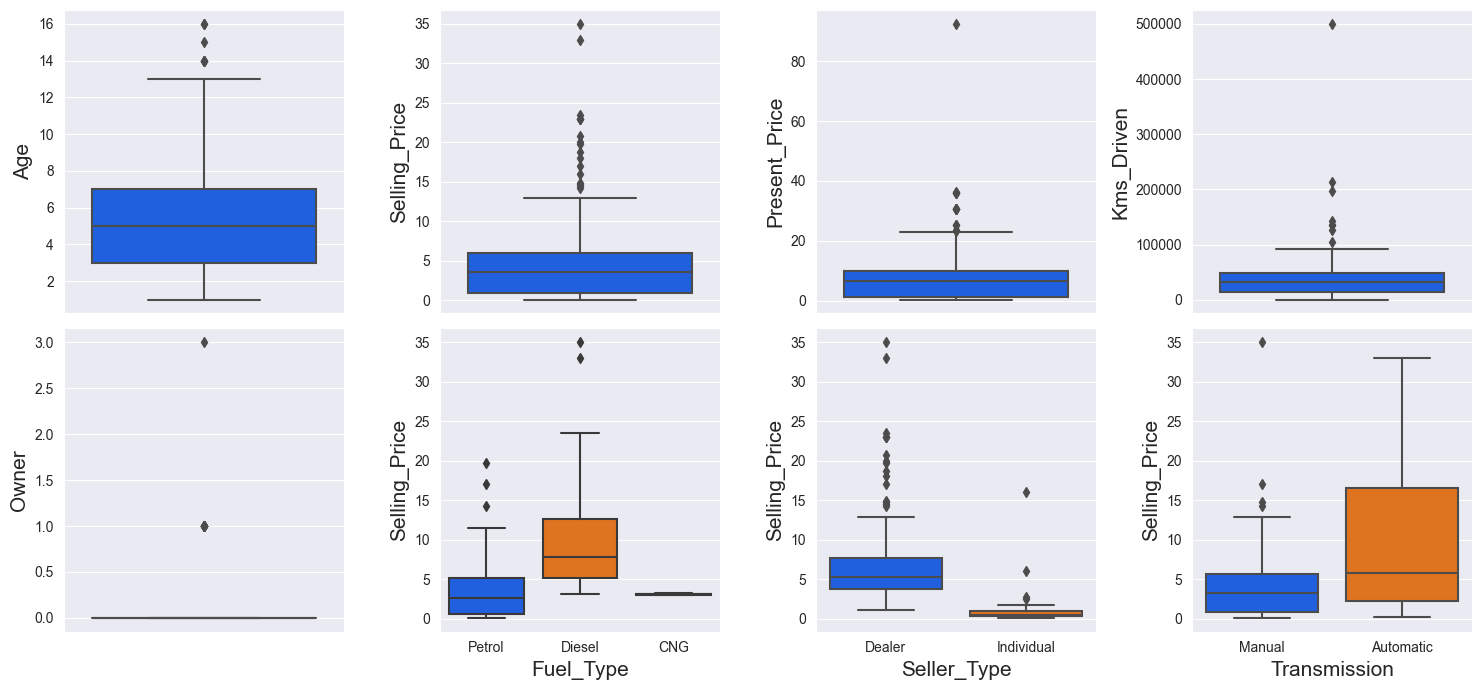

In [11]:
sns.set_style('darkgrid')
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

OrderedCols = np.concatenate([df.select_dtypes(exclude='object').columns.values, 
                              df.select_dtypes(include='object').columns.values])

fig, ax = plt.subplots(2, 4, figsize=(15,7),dpi=100)

for i,col in enumerate(OrderedCols):
    x = i//4
    y = i%4
    if i<5:
        sns.boxplot(data=df, y=col, ax=ax[x,y])
        ax[x,y].yaxis.label.set_size(15)
    else:
        sns.boxplot(data=df, x=col, y='Selling_Price', ax=ax[x,y])
        ax[x,y].xaxis.label.set_size(15)
        ax[x,y].yaxis.label.set_size(15)

plt.tight_layout()    
plt.show()

In [12]:
outliers_indexes = []
target = 'Selling_Price'

for col in df.select_dtypes(include='object').columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3-q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())

for col in df.select_dtypes(exclude='object').columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
    outlier_samples = df[(df[col] < minimum) | (df[col] > maximum)]
    outliers_indexes.extend(outlier_samples.index.tolist())
    
outliers_indexes = list(set(outliers_indexes))
print('找到共{}個異常值 , index為:\n\n{}'.format(len(outliers_indexes), outliers_indexes))

找到共38個異常值 , index為:

[27, 37, 39, 50, 51, 52, 53, 54, 179, 184, 58, 59, 189, 62, 63, 64, 191, 66, 192, 196, 69, 193, 198, 201, 77, 205, 79, 80, 82, 84, 85, 86, 92, 93, 96, 97, 106, 241]


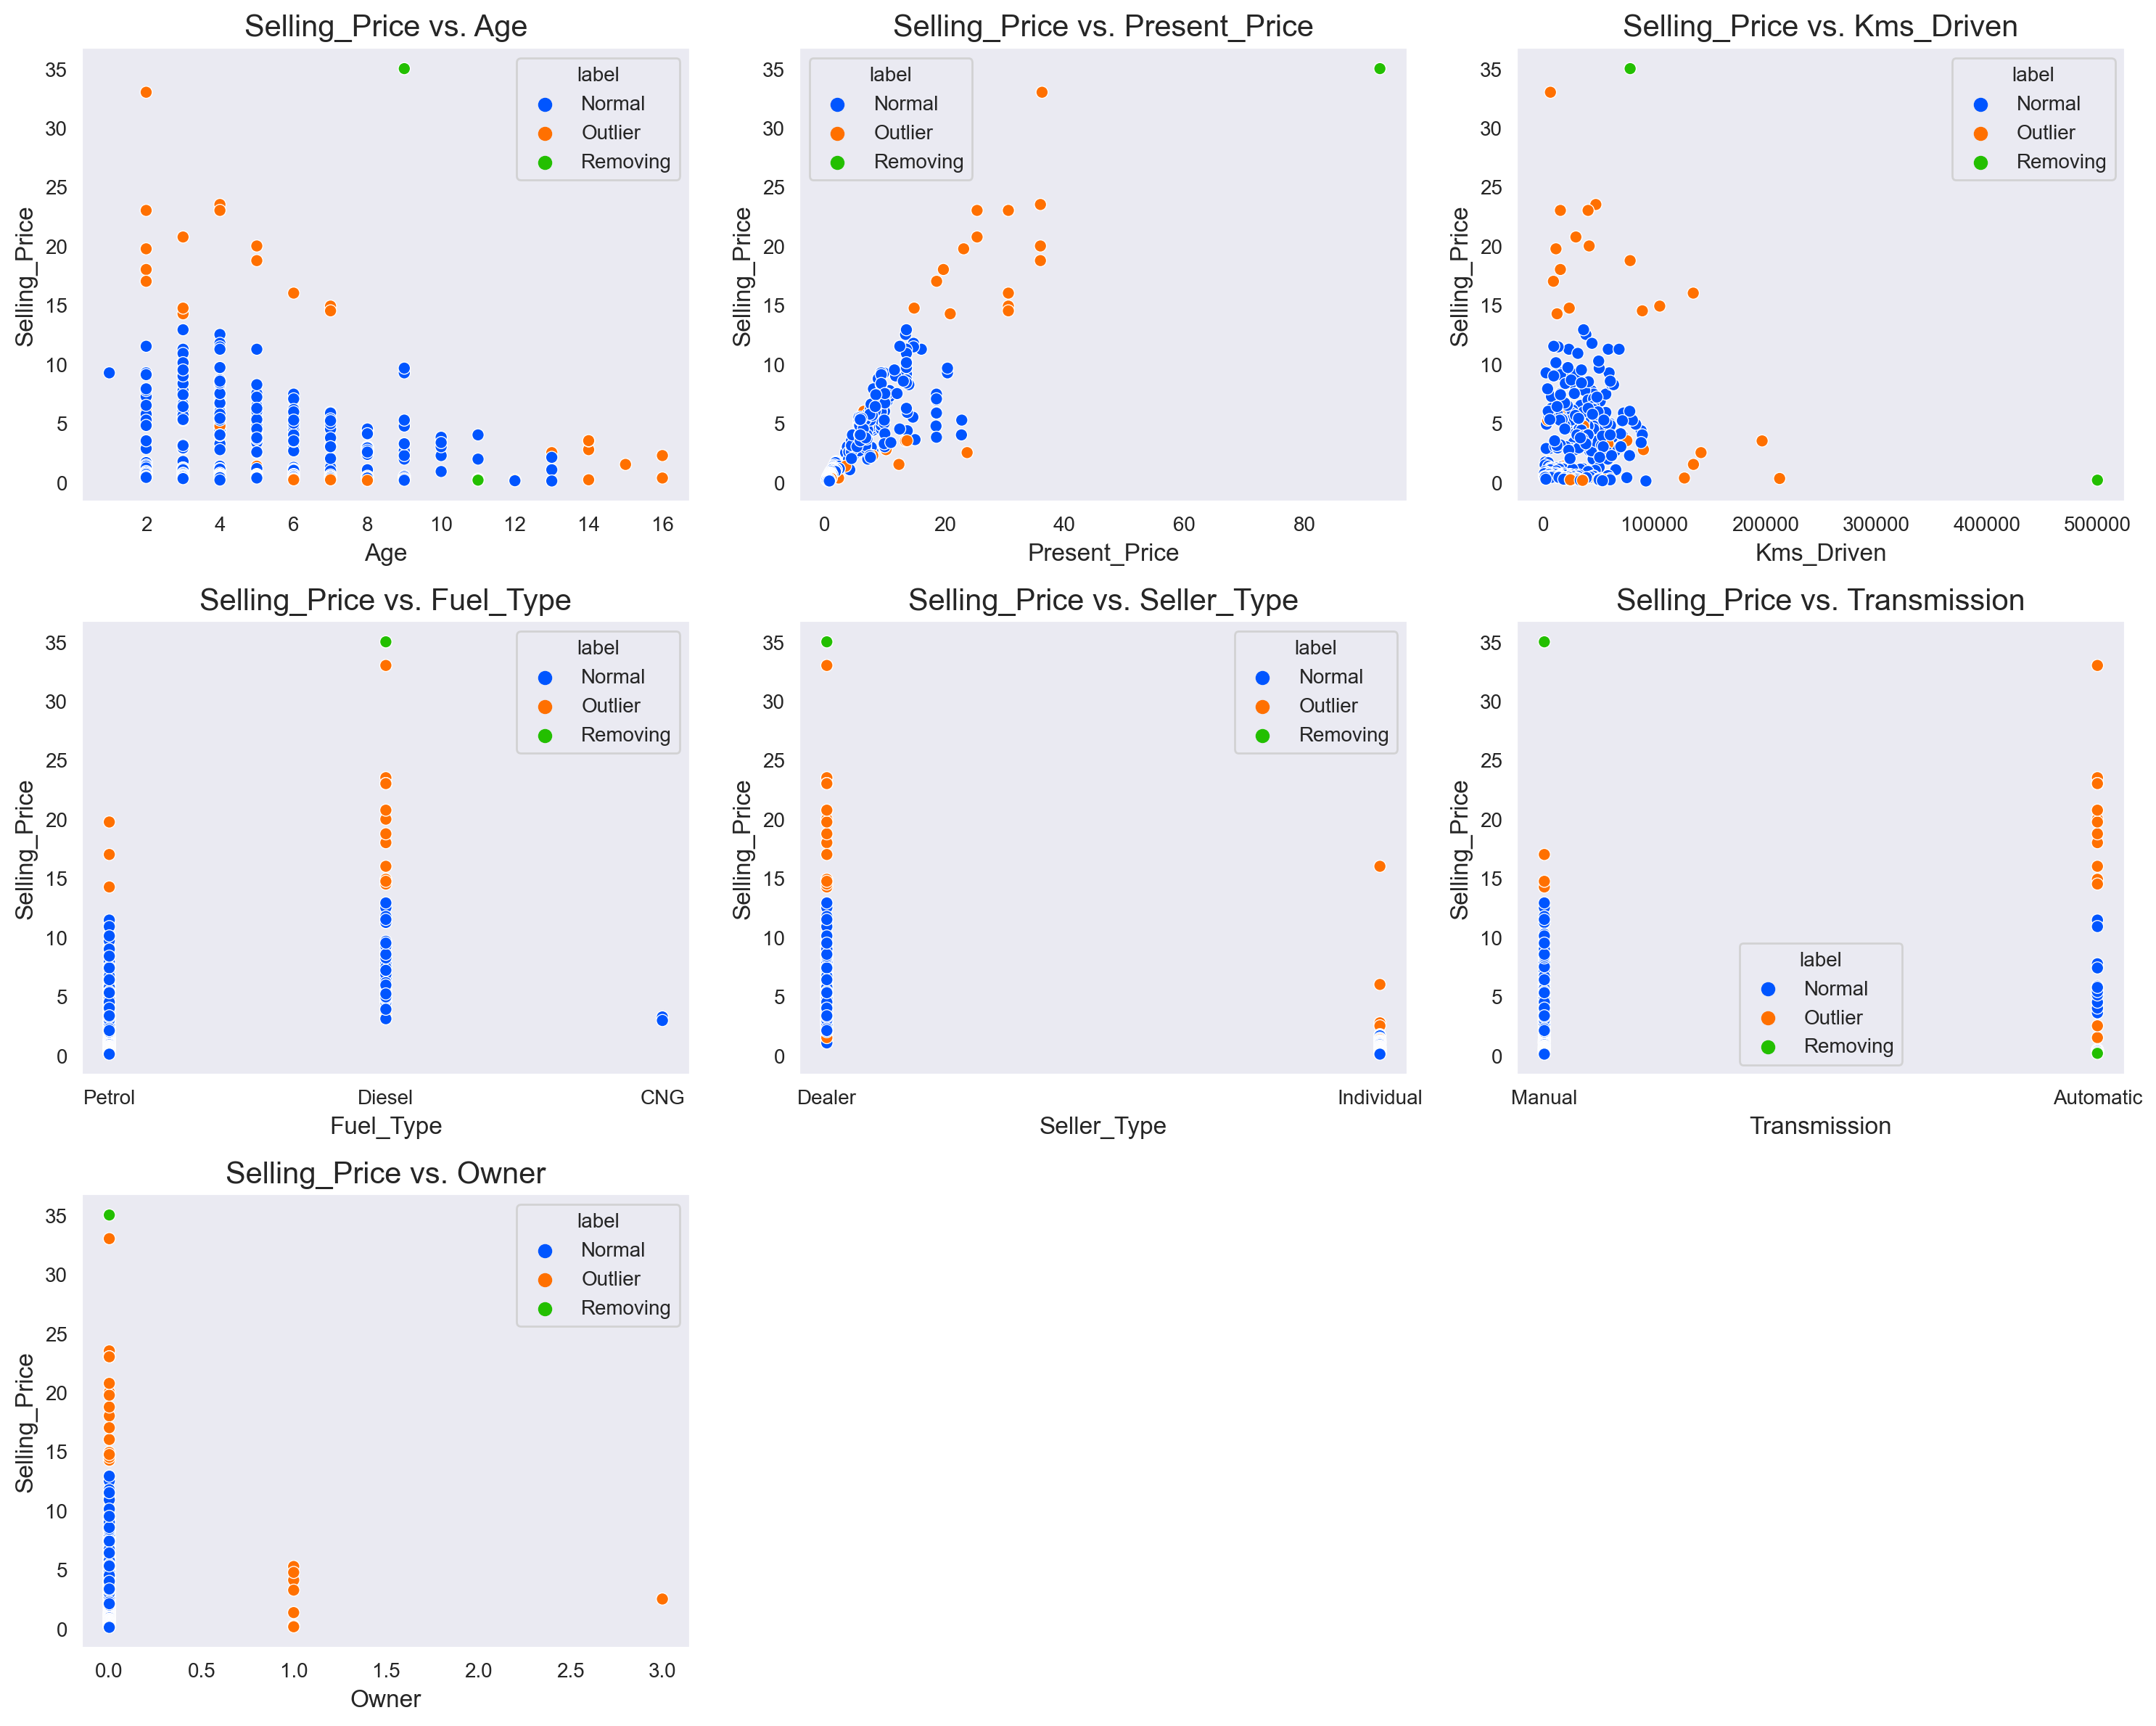

In [13]:
df1 = df.copy()
df1['label'] = 'Normal'
df1.loc[outliers_indexes,'label'] = 'Outlier'

removing_indexes = []
removing_indexes.extend(df1[df1[target]>33].index)
removing_indexes.extend(df1[df1['Kms_Driven']>400000].index)
df1.loc[removing_indexes,'label'] = 'Removing'

target = 'Selling_Price'
features = df.columns.drop(target)
colors = ['#0055ff','#ff7000','#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(nrows=3 ,ncols=3, figsize=(15,12), dpi=200)

for i in range(len(features)):
    x=i//3
    y=i%3
    sns.scatterplot(data=df1, x=features[i], y=target, hue='label', ax=ax[x,y])
    ax[x,y].set_title('{} vs. {}'.format(target, features[i]), size = 15)
    ax[x,y].set_xlabel(features[i], size = 12)
    ax[x,y].set_ylabel(target, size = 12)
    ax[x,y].grid()

ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

In [14]:
removing_indexes = list(set(removing_indexes))
removing_indexes

[196, 86]

In [15]:
df1 = df.copy()
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)

### One-Hot Encoding

In [16]:
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']

df1 = pd.get_dummies(df1, columns=CatCols, drop_first=True)
df1.head(5)

,Age,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,5,3.35,5.59,27000,0,0,1,0,1
1,6,4.75,9.54,43000,0,1,0,0,1
2,2,7.25,9.85,6900,0,0,1,0,1
3,8,2.85,4.15,5200,0,0,1,0,1
4,5,4.60,6.87,42450,0,1,0,0,1


## Correlation Analysis

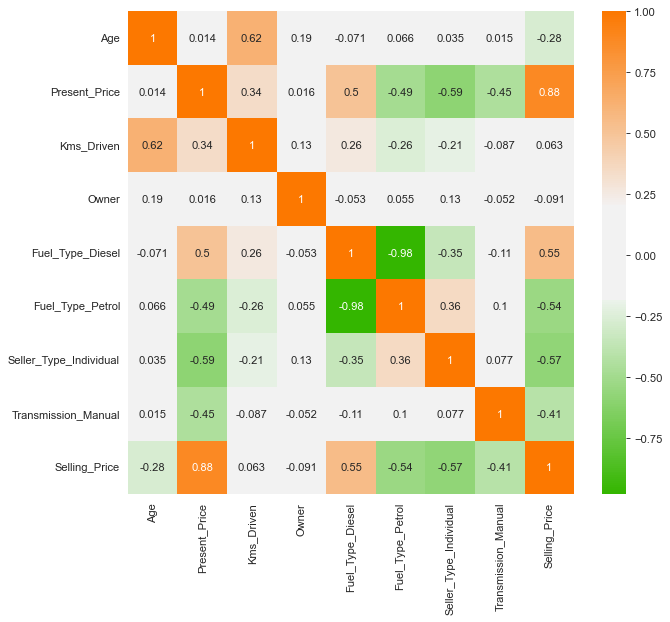

In [17]:
target = 'Selling_Price'
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(9, 8), dpi=80)
ax = sns.heatmap(pd.concat([df1.drop(target,axis=1), df1[target]],axis=1).corr(), annot=True, cmap=cmap)
plt.show()

## Function

In [18]:
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)
    
    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE' ,'R2-Score'], columns=[model_name])

In [19]:
def residuals(model, X_test, y_test):
    y_pred = model.predict(X_test)
    df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [20]:
def linear_assumption(model, X_test, y_test):
    df_results = residuals(model, X_test, y_test)
    
    fig, ax = plt.subplots(1,2, figsize=(15,6), dpi=80)
    sns.regplot(x='Predicted', y='Actual', data=df_results, lowess=True, ax=ax[0],
                color='#0055ff', line_kws={'color':'#ff7000','ls':'--','lw':2.5})
    ax[0].set_title('Actual vs. Predicted Values', fontsize=15)
    ax[0].set_xlabel('Predicted', fontsize=12)
    ax[0].set_ylabel('Actual', fontsize=12)

    sns.regplot(x='Predicted', y='Residuals', data=df_results, lowess=True, ax=ax[1],
                color='#0055ff', line_kws={'color':'#ff7000','ls':'--','lw':2.5})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=15)
    ax[1].set_xlabel('Predicted', fontsize=12)
    ax[1].set_ylabel('Residuals', fontsize=12) 

In [21]:
def normal_errors_assumption(model, X_test, y_test, p_value_thresh=0.05):
    df_results = residuals(model, X_test, y_test)
    
    p_value = normal_ad(df_results['Residuals'])[1]

    print('\nP值為:  ', np.round(p_value,6))
    if p_value < p_value_thresh:
        print('推翻假設，非常態分佈。') 
    else:
        print('假設成立，常態分佈。')

    fig, ax = plt.subplots(1,2, figsize=(15,6), dpi=80)
    
    sns.histplot(data=df_results, x='Residuals', kde=True, ax=ax[0], bins=15, 
                 color='#0055ff', edgecolor='none', alpha=0.4, line_kws={'lw': 2.5})
    ax[0].set_xlabel('Residuals', fontsize=12)
    ax[0].set_ylabel('Count', fontsize=12)
    ax[0].set_title('Distribution of Residuals', fontsize=15)
    textstr = '\n'.join((
        r'$\mu=%.2f$' %np.mean(df_results['Residuals']),
        r'$\sigma=%.2f$' %np.std(df_results['Residuals']),
        ))
    ax[0].text(0.7, 0.9, textstr, transform=ax[0].transAxes, fontsize=15, verticalalignment='top',
                 bbox=dict(boxstyle='round',facecolor='#509aff', edgecolor='black', pad=0.5))
                 
    stats.probplot(df_results['Residuals'], dist="norm", plot= ax[1])
    ax[1].set_title("Residuals Q-Q Plot", fontsize=15)
    ax[1].set_xlabel('Theoretical Quantiles', fontsize=12)
    ax[1].set_ylabel('Ordered Values', fontsize=12)
    ax[1].get_lines()[0].set_markerfacecolor('#509aff')
    ax[1].get_lines()[1].set_color('#ff7000')
    ax[1].get_lines()[1].set_linewidth(2.5)
    ax[1].get_lines()[1].set_linestyle('--')
    ax[1].legend(['Actual','Theoretical'])
    
    plt.show()

## Linear Regression Model

In [22]:
X = df1.drop('Selling_Price', axis=1)
y = df1['Selling_Price']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [24]:
pd.DataFrame(data = np.append(linear_reg.intercept_ , linear_reg.coef_), 
             index = ['Intercept']+[col+" Coef." for col in X.columns], columns=['Value']).sort_values('Value', ascending=False)

,Value
Intercept,4.302488
Present_Price Coef.,3.492729
Fuel_Type_Diesel Coef.,0.850217
Fuel_Type_Petrol Coef.,0.207319
Transmission_Manual Coef.,0.027375
Owner Coef.,-0.232722
Seller_Type_Individual Coef.,-0.377334
Kms_Driven Coef.,-0.589672
Age Coef.,-0.936339


In [25]:
model_evaluation(linear_reg, X_test_scaled, y_test, 'Linear Reg.')

,Linear Reg.
MAE,1.198867
MSE,3.714913
RMSE,1.927411
R2-Score,0.887245


In [26]:
linear_reg_cv = LinearRegression()
scaler = StandardScaler()
pipeline = make_pipeline(StandardScaler(),  LinearRegression())

kf = KFold(n_splits=6, shuffle=True, random_state=0) 
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
result = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

MAE_mean = (-result['test_neg_mean_absolute_error']).mean()
MAE_std = (-result['test_neg_mean_absolute_error']).std()
MSE_mean = (-result['test_neg_mean_squared_error']).mean()
MSE_std = (-result['test_neg_mean_squared_error']).std()
RMSE_mean = (-result['test_neg_root_mean_squared_error']).mean()
RMSE_std = (-result['test_neg_root_mean_squared_error']).std()
R2_Score_mean = result['test_r2'].mean()
R2_Score_std = result['test_r2'].std()

pd.DataFrame({'Mean': [MAE_mean,MSE_mean,RMSE_mean,R2_Score_mean], 'Std': [MAE_std,MSE_std,RMSE_std,R2_Score_std]},
             index=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

,Mean,Std
MAE,1.154774,0.147377
MSE,3.131755,1.314319
RMSE,1.728702,0.378609
R2-Score,0.855703,0.033720


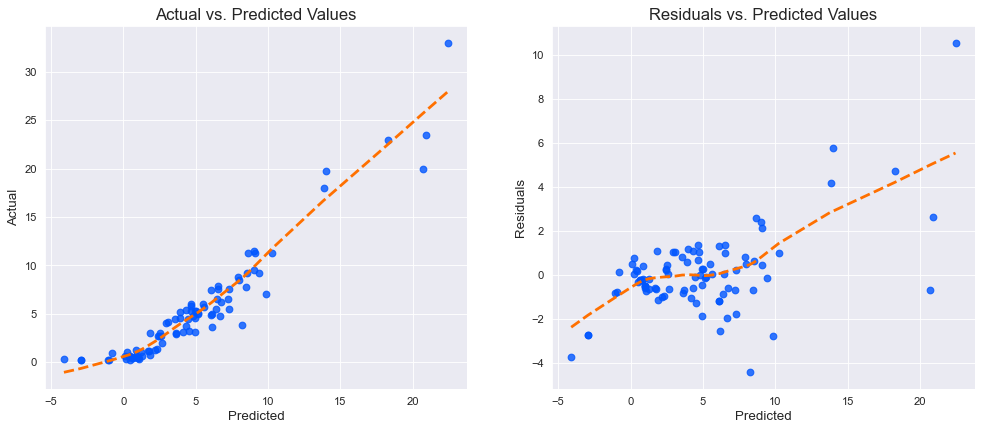

In [27]:
linear_assumption(linear_reg, X_test_scaled, y_test)


P值為:   0.0
推翻假設，非常態分佈。


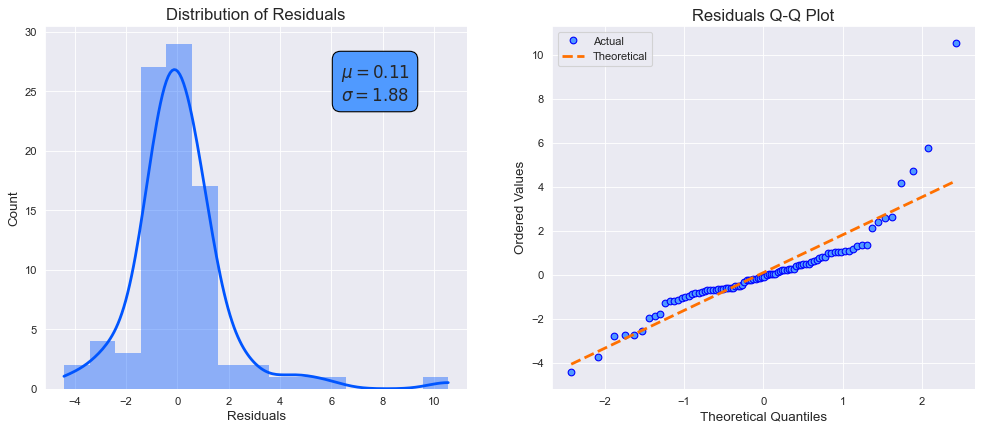

In [28]:
normal_errors_assumption(linear_reg, X_test_scaled, y_test)

## Box-Cox

In [29]:
fitted_lambda = pd.Series(np.zeros(len(df1.columns), dtype=np.float64), index=df1.columns)

y_train, fitted_lambda['Selling_Price'] = stats.boxcox(y_train+1)
for col in X_train.columns:
    X_train[col], fitted_lambda[col] = stats.boxcox(X_train[col]+1)
    
fitted_lambda

Age                       -0.360231
Selling_Price             -0.035121
Present_Price              0.078725
Kms_Driven                 0.350131
Owner                    -30.152327
Fuel_Type_Diesel          -7.291035
Fuel_Type_Petrol           6.903209
Seller_Type_Individual    -2.568079
Transmission_Manual       14.414394
dtype: float64

In [30]:
y_test = stats.boxcox(y_test+1, fitted_lambda['Selling_Price'])
for col in X_test.columns:
    X_test[col] = stats.boxcox(X_test[col]+1, fitted_lambda[col])

In [31]:
y_train = pd.DataFrame(y_train, index=X_train.index, columns=['Selling_Price'])
y_test = pd.DataFrame(y_test, index=X_test.index, columns=['Selling_Price'])

X_boxcox = pd.concat([X_train, X_test])
y_boxcox = pd.concat([y_train, y_test])

df_boxcox = pd.concat([X_boxcox, y_boxcox], axis=1)
df_boxcox.sort_index(inplace=True)

del df_boxcox['Fuel_Type_Petrol']

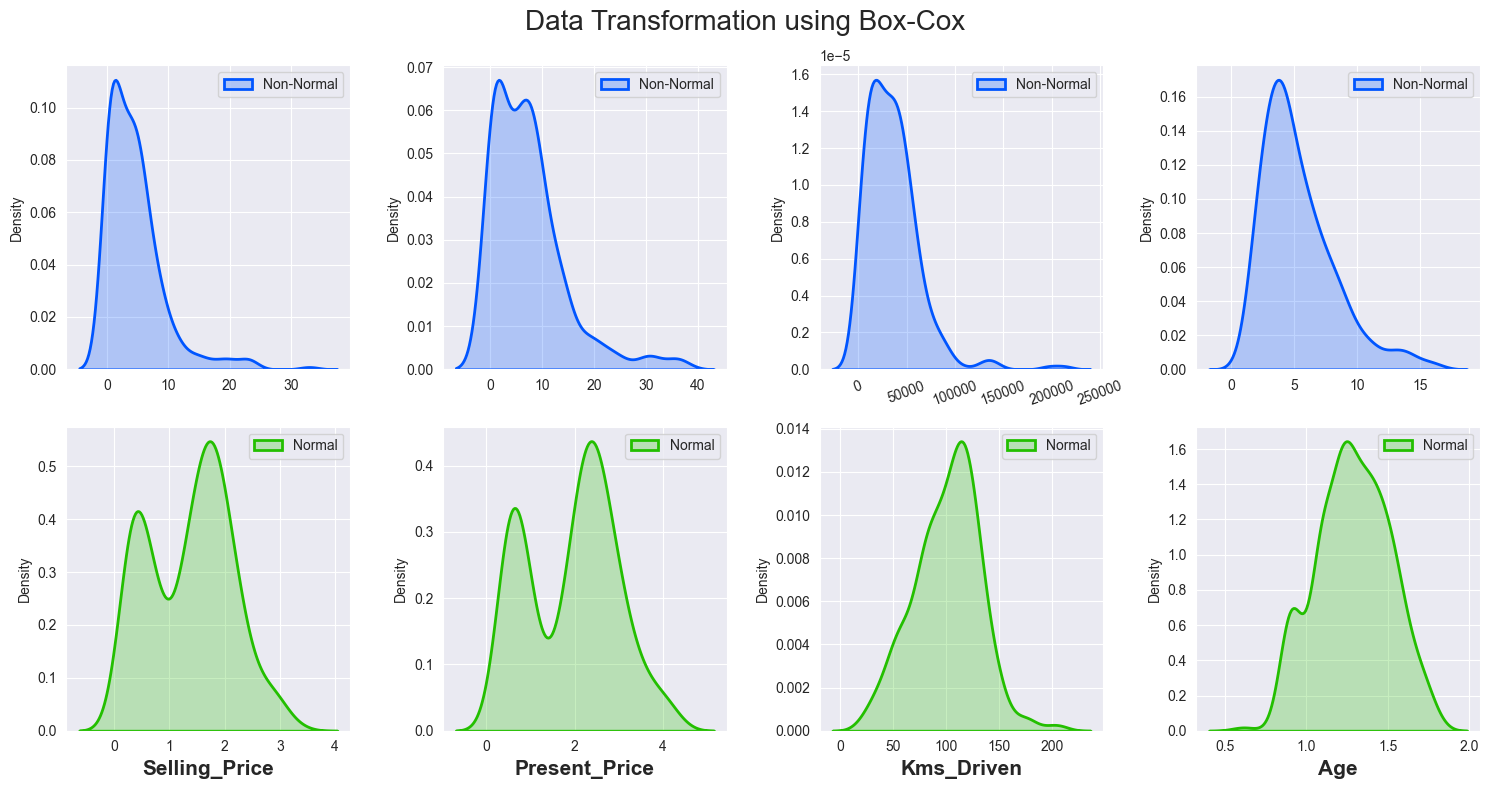

In [32]:
fig, ax = plt.subplots(2, 4, figsize=(15,8), dpi=100)
columns = ['Selling_Price', 'Present_Price', 'Kms_Driven', 'Age']

for i,col in enumerate(columns):
    sns.kdeplot(df1[col], label="Non-Normal", fill=True, color='#0055ff', linewidth=2, ax=ax[0,i])
    sns.kdeplot(df_boxcox[col], label="Normal", fill=True, color='#23bf00', linewidth=2, ax=ax[1,i])  
    ax[0,i].set_xlabel('', fontsize=15)
    ax[1,i].set_xlabel(col, fontsize=15, fontweight='bold')
    ax[0,i].legend(loc="upper right")
    ax[1,i].legend(loc="upper right")

ax[0,2].tick_params(axis='x', labelrotation = 20)
plt.suptitle('Data Transformation using Box-Cox', fontsize=20)
plt.tight_layout()
plt.show()

## Polynomial Regression

In [33]:
X = df_boxcox.drop('Selling_Price', axis=1)
y = df_boxcox['Selling_Price']

In [34]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X_poly = pd.DataFrame(X_poly, columns=poly_features.get_feature_names_out(X.columns))
X_poly.head(5)

,Age,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Manual,Age^2,Age Present_Price,Age Kms_Driven,...,Owner^2,Owner Fuel_Type_Diesel,Owner Seller_Type_Individual,Owner Transmission_Manual,Fuel_Type_Diesel^2,Fuel_Type_Diesel Seller_Type_Individual,Fuel_Type_Diesel Transmission_Manual,Seller_Type_Individual^2,Seller_Type_Individual Transmission_Manual,Transmission_Manual^2
0,1.320187,2.032688,98.846654,0.0,0.000000,0.0,1514.777352,1.742893,2.683528,130.496050,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,2.294550e+06
1,1.398824,2.587658,116.843776,0.0,0.136279,0.0,1514.777352,1.956709,3.619679,163.443905,...,0.0,0.0,0.0,0.0,0.018572,0.0,206.432287,0.0,0.0,2.294550e+06
2,0.907273,2.622591,60.223871,0.0,0.000000,0.0,1514.777352,0.823145,2.379406,54.639502,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,2.294550e+06
3,1.518024,1.749435,54.276845,0.0,0.000000,0.0,1514.777352,2.304398,2.655684,82.393575,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,2.294550e+06
4,1.320187,2.240043,116.305479,0.0,0.136279,0.0,1514.777352,1.742893,2.957275,153.544961,...,0.0,0.0,0.0,0.0,0.018572,0.0,206.432287,0.0,0.0,2.294550e+06


In [35]:
poly_features_names = poly_features.get_feature_names_out(X.columns)
len(poly_features_names)

35

In [36]:
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, test_size=0.3, random_state=0)

scaler = StandardScaler()
scaler.fit(X_poly_train)

X_poly_train = scaler.transform(X_poly_train)
X_poly_train = pd.DataFrame(X_poly_train, columns=poly_features_names)

X_poly_test = scaler.transform(X_poly_test)
X_poly_test = pd.DataFrame(X_poly_test, columns=poly_features_names)

polynomial_reg = LinearRegression()
polynomial_reg.fit(X_poly_train, y_poly_train)

LinearRegression()

In [37]:
model_evaluation(polynomial_reg, X_poly_test, y_poly_test, 'Polynomial Reg. Test')

,Polynomial Reg. Test
MAE,0.088163
MSE,0.011432
RMSE,0.106920
R2-Score,0.981584


In [38]:
model_evaluation(polynomial_reg, X_poly_train, y_poly_train, 'Polynomial Reg. Train')

,Polynomial Reg. Train
MAE,0.064327
MSE,0.006435
RMSE,0.080222
R2-Score,0.988170


In [39]:
pipeline = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),  LinearRegression())

kf = KFold(n_splits=6, shuffle=True, random_state=0) 
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
result2 = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

MAE_mean = (-result2['test_neg_mean_absolute_error']).mean()
MAE_std = (-result2['test_neg_mean_absolute_error']).std()
MSE_mean = (-result2['test_neg_mean_squared_error']).mean()
MSE_std = (-result2['test_neg_mean_squared_error']).std()
RMSE_mean = (-result2['test_neg_root_mean_squared_error']).mean()
RMSE_std = (-result2['test_neg_root_mean_squared_error']).std()
R2_Score_mean = result2['test_r2'].mean()
R2_Score_std = result2['test_r2'].std()

pd.DataFrame({'Mean': [MAE_mean,MSE_mean,RMSE_mean,R2_Score_mean], 'Std': [MAE_std,MSE_std,RMSE_std,R2_Score_std]},
             index=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

,Mean,Std
MAE,0.079857,0.009664
MSE,0.011984,0.005636
RMSE,0.106877,0.023692
R2-Score,0.978172,0.010858


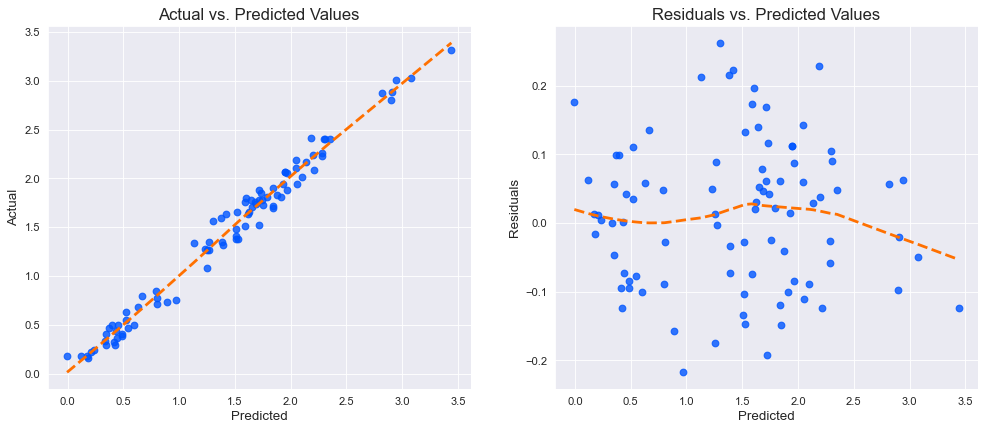

In [40]:
linear_assumption(polynomial_reg, X_poly_test, y_poly_test)


P值為:   0.450843
假設成立，常態分佈。


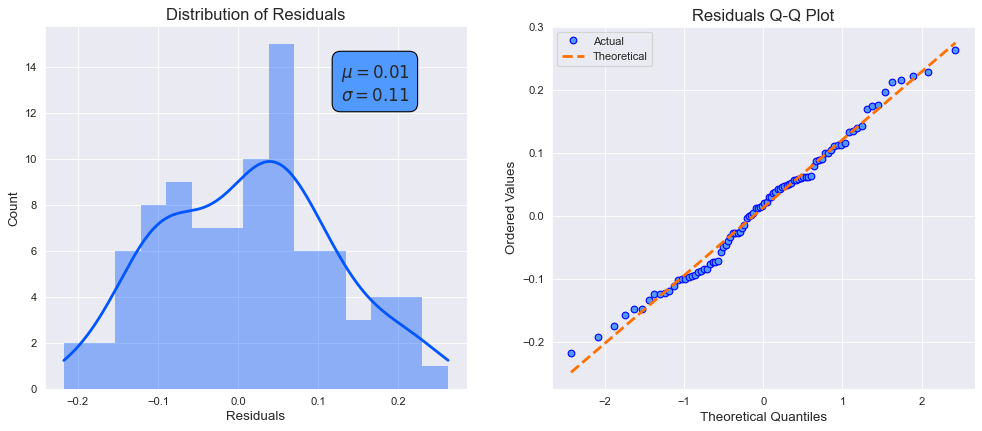

In [41]:
normal_errors_assumption(polynomial_reg, X_poly_test, y_poly_test)